<!-- <img width="800px" src="../fidle/img/header.svg"></img>  -->

# <!-- TITLE --> Regression with a Dense Neural Network (DNN) for Boston Housig Prices Prediction
  <!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Predicts **housing prices** from a set of house features.
 - Understanding the principle and the architecture of a regression with a dense neural network with backup and restore of the trained model.

The **[Boston Housing Prices Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)** consists of price of houses in various places in Boston.  
Alongside with price, the dataset also provide these information :

 - CRIM: This is the per capita crime rate by town
 - ZN: This is the proportion of residential land zoned for lots larger than 25,000 sq.ft
 - INDUS: This is the proportion of non-retail business acres per town
 - CHAS: This is the Charles River dummy variable (this is equal to 1 if tract bounds river; 0 otherwise)
 - NOX: This is the nitric oxides concentration (parts per 10 million)
 - RM: This is the average number of rooms per dwelling
 - AGE: This is the proportion of owner-occupied units built prior to 1940
 - DIS: This is the weighted distances to five Boston employment centers
 - RAD: This is the index of accessibility to radial highways
 - TAX: This is the full-value property-tax rate per 10,000 dollars
 - PTRATIO: This is the pupil-teacher ratio by town
 - B: This is calculated as 1000(Bk — 0.63)^2, where Bk is the proportion of people of African American descent by town
 - LSTAT: This is the percentage lower status of the population
 - MEDV: This is the median value of owner-occupied homes in 1000 dollars

**[Reference Notebooks](https://gricad-gitlab.univ-grenoble-alpes.fr/talks/fidle/-/tree/master/BHPD.Keras3?ref_type=heads)**

## What we're going to do :

 - (Retrieve data)
 - (Preparing the data)
 - (Build a model)
 - Train and save the model
 - Restore saved model
 - Evaluate the model
 - Make some predictions

## 1. Import and init

In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'torch'
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

## 2. Prepare the data
- Split data, We will use 80% of the data for training and 20% for validation.  
- x will be input data and y the expected output

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.boston_housing.load_data(test_split=.2, seed=113)

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
print('x_test  : ',x_test.shape,  'y_test  : ',y_test.shape)

x_train :  (404, 13) y_train :  (404,)
x_test  :  (102, 13) y_test  :  (102,)


## 3. Data normalization
**Note :**
 - All input data must be normalized, train and test.  
 - To do this we will subtract the mean and divide by the standard deviation.  
 - But test data should not be used in any way, even for normalization.  
 - The mean and the standard deviation will therefore only be calculated with the train data.

In [ ]:
mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

x_train, y_train = np.array(x_train), np.array(y_train)
x_test,  y_test  = np.array(x_test),  np.array(y_test)

## 4. Build a model
More informations about :
 - [Optimizer](https://keras.io/api/optimizers)
 - [Activation](https://keras.io/api/layers/activations)
 - [Loss](https://keras.io/api/losses)
 - [Metrics](https://keras.io/api/metrics)

In [ ]:
def get_model_v1(shape):

  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape, name="InputLayer"))
  model.add(keras.layers.Dense(128, activation='relu', name='Dense_n1'))
  model.add(keras.layers.Dense(64, activation='relu', name='Dense_n2'))
  #model.add(keras.layers.Dense(64, activation=keras.layers.ELU(alpha=1.0), name='Dense_n2'))
  model.add(keras.layers.Dense(1, name='Output'))

  model.compile(optimizer = 'rmsprop',
                loss      = 'mse',
                metrics   = ['mae', 'mse'] )
  return model

In [ ]:
model=get_model_v1( (13,) )

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Dense_n1 (Dense)                     │ (None, 128)                 │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_n2 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,113 (39.50 KB)

 Trainable params: 10,113 (39.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# os.makedirs(f'{run_dir}/models',   mode=0o750, exist_ok=True)
# save_dir = f'{run_dir}/models/best_model.keras'
save_dir = './best_model.keras'

savemodel_callback = keras.callbacks.ModelCheckpoint(filepath=save_dir, monitor='val_mae', mode='max', save_best_only=True)

Mounted at /content/drive


## 5. Train the model and save the best model

In [ ]:
history = model.fit(x_train,
                    y_train,
                    epochs          = 50,
                    batch_size      = 10,
                    verbose         = 1,
                    validation_data = (x_test, y_test),
                    callbacks       = [savemodel_callback])

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - loss: 465.4669 - mae: 19.2042 - mse: 465.4669 - val_loss: 174.9588 - val_mae: 10.5169 - val_mse: 174.9588
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 116.2268 - mae: 8.1347 - mse: 116.2268 - val_loss: 99.9093 - val_mae: 7.3577 - val_mse: 99.9093
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 90.1751 - mae: 6.7433 - mse: 90.1751 - val_loss: 84.7128 - val_mae: 6.8936 - val_mse: 84.7128
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 83.7560 - mae: 6.5454 - mse: 83.7560 - val_loss: 74.4100 - val_mae: 6.0042 - val_mse: 74.4100
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 67.9096 - mae: 5.5937 - mse: 67.9096 - val_loss: 69.4308 - val_mae: 6.5585 - val_mse: 69.4308
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 71.7733 - mae: 6.2083 - mse: 71.7733 - val_loss: 62.2424 - val_mae: 5.6755 - val_mse: 62.2424
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 66.5589 - mae: 5.

In [ ]:
%ls

best_model.keras  drive/  sample_data/


In [ ]:
#!cp -r "/content/best_model.keras" "/content/drive/MyDrive/PyDayBCN2024/Colab Notebooks/"

## 6. Reload the model

In [ ]:
loaded_model = keras.models.load_model('./best_model.keras')
loaded_model.summary()
print("Loaded.")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Dense_n1 (Dense)                     │ (None, 128)                 │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_n2 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,228 (79.02 KB)

 Trainable params: 10,113 (39.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,115 (39.51 KB)

Loaded.


## 7. Model evaluation

In [ ]:
print("min( val_mae ) : {:.4f}".format( min(history.history["val_mae"]) ) )

min( val_mae ) : 5.1831


In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 51.2012
x_test / mae       : 5.3555
x_test / mse       : 51.2012


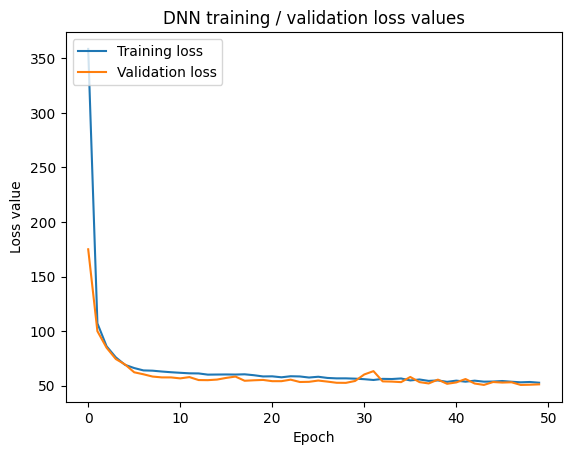

In [ ]:
# Visualize model training history

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('DNN training / validation loss values')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

## 8. Make a new prediction

In [ ]:
my_data = [ 1.26425925, -0.48522739,  1.0436489 , -0.23112788,  1.37120745,
           -2.14308942,  1.13489104, -1.06802005,  1.71189006,  1.57042287,
            0.77859951,  0.14769795,  2.7585581 ]
real_price = 10.4

my_data=np.array(my_data).reshape(1,13)

In [ ]:
predictions = loaded_model.predict(my_data, verbose=0)
print("Prediction : {:.2f} K$".format(predictions[0][0]))
print("Reality    : {:.2f} K$".format(real_price))

Prediction : 3.08 K$
Reality    : 10.40 K$


## 9. Prediction using Numpy

In [ ]:
# Save the trained model to CSV files
model = keras.models.load_model(f'./best_model.keras')

# Iterate over each layer's weights and save them to CSV
for i, layer in enumerate(model.layers):
    weights = layer.get_weights()  # This returns a list of NumPy arrays (weights and biases)

    if weights:  # Some layers like activation don't have weights
        # Save weights and biases for each layer in separate CSV files
        np.savetxt(f'layer_{i}_weights.csv', weights[0], delimiter=",")
        if len(weights) > 1:
            np.savetxt(f'layer_{i}_biases.csv', weights[1], delimiter=",")

In [ ]:
# Extracting model configuration (architecture)
model_config = model.get_config()  # This contains the architecture of the model
#model_config

In [ ]:
# Define activation functions

# ReLU activation
def relu(x):
    return np.maximum(0, x)

# ELU activation
def elu(x, alpha=1.0):
    return np.where(x >= 0, x, alpha * (np.exp(x) - 1))

# Load weights and biases
dense_n1_weights = np.loadtxt('layer_0_weights.csv', delimiter=',')
dense_n1_biases = np.loadtxt('layer_0_biases.csv', delimiter=',')

dense_n2_weights = np.loadtxt('layer_1_weights.csv', delimiter=',')
dense_n2_biases = np.loadtxt('layer_1_biases.csv', delimiter=',')

output_weights = np.loadtxt('layer_2_weights.csv', delimiter=',')
output_biases = np.loadtxt('layer_2_biases.csv', delimiter=',')

# Define a sample input (replace with your real input data)
new_data_point = my_data
# Step-by-step forward propagation using the weights and biases

# 1. First hidden layer (Dense_n1) with ReLU activation
z1 = np.dot(new_data_point, dense_n1_weights) + dense_n1_biases
a1 = relu(z1)

# 2. Second hidden layer (Dense_n2) with ReLU activation
z2 = np.dot(a1, dense_n2_weights) + dense_n2_biases
a2 = relu(z2)

# 3. Output layer (no activation, regression task)
output = np.dot(a2, output_weights) + output_biases

print("Numpy DNN Prediction : {:.2f} K$   Reality : {:.2f} K$".format(output[0], real_price))

Numpy DNN Prediction : 3.08 K$   Reality : 10.40 K$
